In [1]:
!pip install -q -U  datasets

In [2]:
!pip install -q -U torchinfo

In [20]:
import torch
from torch import nn
from torchinfo import summary
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import List, Tuple, Dict

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model

In [4]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector."""
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        # assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [5]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a MSA block """
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0): # according to Appendix B.1, dropout isn't used after the qkv-projections
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [6]:
class MLPBlock(nn.Module):
    """Creates a MLP layer"""
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [7]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x      #Residual Connection
        x = self.mlp_block(x) + x       #Residual Connection
        return x

In [8]:
class ClassifierHead(nn.Module):
  """Creates a Classifier ViT."""
  def __init__(self,
               embedding_dim: int= 768,
               num_classes:int = 1000):
    super().__init__()
    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim,
                                              out_features=num_classes))

  def forward(self, x):
    x = self.classifier(x)
    return x

In [9]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # Stack 12 (num_transformer_layers) Transformer Encoder blocks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = ClassifierHead(embedding_dim=embedding_dim,
                                         num_classes=num_classes)

    def forward(self, x):

        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) # creates copies of the class embedding batch_size times along 0th dim keeping first and second same

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) # Keeping all batch and taking the first element of x from 197
        return x

In [10]:
MNIST_ViT = ViT(img_size=28,
                 in_channels=1,
                 patch_size=7,
                 num_transformer_layers=3,
                 embedding_dim=49,    # patch**2 *  color channel -> 7 **2 *1 = 49
                 mlp_size=196,
                 num_heads=7,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=10)

In [11]:
summary(model=MNIST_ViT,
        input_size=(32, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 1, 28, 28]      [32, 10]             882                  True
├─PatchEmbedding (patch_embedding)                           [32, 1, 28, 28]      [32, 16, 49]         --                   True
│    └─Conv2d (patcher)                                      [32, 1, 28, 28]      [32, 49, 4, 4]       2,450                True
│    └─Flatten (flatten)                                     [32, 49, 4, 4]       [32, 49, 16]         --                   --
├─Dropout (embedding_dropout)                                [32, 17, 49]         [32, 17, 49]         --                   --
├─Sequential (transformer_encoder)                           [32, 17, 49]         [32, 17, 49]         --                   True
│    └─TransformerEncoderBlock (0)                           [32, 17, 49]         [32, 17, 49]  

# Data

In [12]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

 13%|█▎        | 1310720/9912422 [00:00<00:02, 3663603.46it/s]

100%|██████████| 9912422/9912422 [00:02<00:00, 4622949.59it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 671711.02it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3480275.14it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4540164.15it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



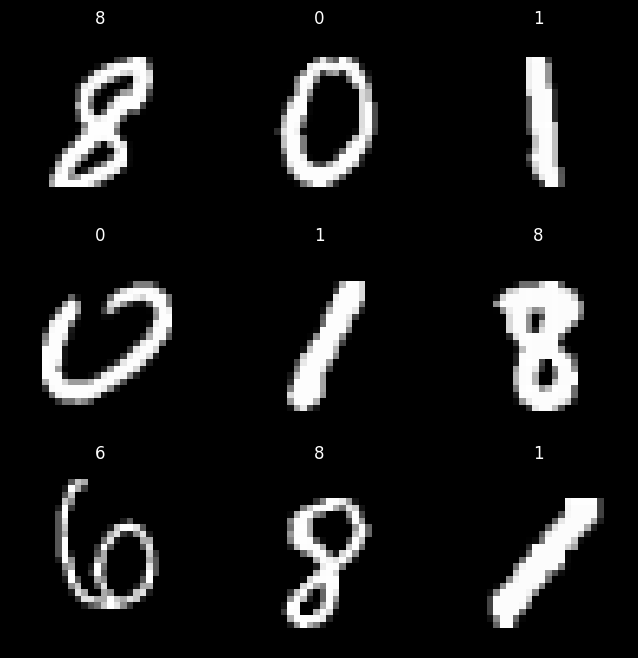

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:
img.shape


torch.Size([1, 28, 28])

In [15]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


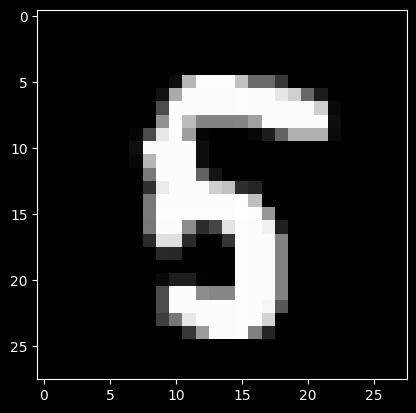

Label: 5


In [16]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [17]:
train_features[0].shape

torch.Size([1, 28, 28])

# Training

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

In [21]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    model.to(device)

    # Train
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = 0, 0
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item() 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        train_loss = train_loss / len(train_dataloader)
        train_acc = train_acc / len(train_dataloader)
        
        # Test
        model.eval() 
        test_loss, test_acc = 0, 0
        with torch.inference_mode():
            for batch, (X, y) in enumerate(test_dataloader):
                X, y = X.to(device), y.to(device)
                test_pred_logits = model(X)
                loss = loss_fn(test_pred_logits, y)
                test_loss += loss.item()
                test_pred_labels = test_pred_logits.argmax(dim=1)
                test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [22]:
optimizer = torch.optim.Adam(params=MNIST_ViT.parameters(),
                             lr=3e-2, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 

loss_fn = torch.nn.CrossEntropyLoss()


results = train(model=MNIST_ViT,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]